In [35]:
import pandas as pd
import numpy as np

n = ['id', 'date', 'name', 'text', 'typr', 'rep', 'rtw', 'faw', 'stcount', 'foll', 'frien', 'listcount']
data_positive = pd.read_csv('positive.csv', sep=';', error_bad_lines=False, names=n, usecols=['text'])
data_negative = pd.read_csv('negative.csv', sep=';', error_bad_lines=False, names=n, usecols=['text'])

sample_size = min(data_positive.shape[0], data_negative.shape[0])
raw_data = np.concatenate((data_positive['text'].values[:sample_size],
                           data_negative['text'].values[:sample_size]), axis=0)
labels = [1] * sample_size + [0] * sample_size

In [36]:
import re

def preprocess_text(text):
    text = text.lower().replace("ё", "е")
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'URL', text)
    text = re.sub('@[^\s]+', 'USER', text)
    text = re.sub('[^a-zA-Zа-яА-Я1-9]+', ' ', text)
    text = re.sub(' +', ' ', text)
    return text.strip()


data = [preprocess_text(t) for t in raw_data]

In [37]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=2)

In [38]:
from keras import backend as K


def precision(y_true, y_pred):
    """Precision metric.

    Only computes a batch-wise average of precision.

    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    """Recall metric.

    Only computes a batch-wise average of recall.

    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

In [39]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

SENTENCE_LENGTH = 26
NUM = 100000

def get_sequences(tokenizer, x):
    sequences = tokenizer.texts_to_sequences(x)
    return pad_sequences(sequences, maxlen=SENTENCE_LENGTH)

tokenizer = Tokenizer(num_words=NUM)
tokenizer.fit_on_texts(x_train)

x_train_seq = get_sequences(tokenizer, x_train)
x_test_seq = get_sequences(tokenizer, x_test)

In [40]:
from gensim.models import Word2Vec
# Загружаем обученную модель
w2v_model = Word2Vec.load('model.w2v')
DIM = w2v_model.vector_size 
# Инициализируем матрицу embedding слоя нулями
embedding_matrix = np.zeros((NUM, DIM))
# Добавляем NUM=100000 наиболее часто встречающихся слов из обучающей выборки в embedding слой
for word, i in tokenizer.word_index.items():
    if i >= NUM:
        break
    if word in w2v_model.wv.vocab.keys():
        embedding_matrix[i] = w2v_model.wv[word]

In [41]:
from keras.layers import Input
from keras.layers.embeddings import Embedding

tweet_input = Input(shape=(SENTENCE_LENGTH,), dtype='int32')
tweet_encoder = Embedding(NUM, DIM, input_length=SENTENCE_LENGTH,
                          weights=[embedding_matrix], trainable=False)(tweet_input)

In [42]:
from keras import optimizers
from keras.layers import Dense, concatenate, Activation, Dropout
from keras.models import Model
from keras.layers.convolutional import Conv1D
from keras.layers.pooling import GlobalMaxPooling1D

branches = []
x = Dropout(0.2)(tweet_encoder)

for size, filters_count in [(2, 10), (3, 10), (4, 10), (5, 10)]:
    for i in range(filters_count):
        branch = Conv1D(filters=1, kernel_size=size, padding='valid', activation='relu')(x)
        branch = GlobalMaxPooling1D()(branch)
        branches.append(branch)

x = concatenate(branches, axis=1)
x = Dropout(0.2)(x)
x = Dense(30, activation='relu')(x)
x = Dense(1)(x)
output = Activation('sigmoid')(x)

model = Model(inputs=[tweet_input], outputs=[output])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[precision, recall, f1])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 26)           0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 26, 200)      20000000    input_3[0][0]                    
__________________________________________________________________________________________________
dropout_5 (Dropout)             (None, 26, 200)      0           embedding_3[0][0]                
__________________________________________________________________________________________________
conv1d_81 (Conv1D)              (None, 25, 1)        401         dropout_5[0][0]                  
__________________________________________________________________________________________________
conv1d_82 

In [43]:
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint("cnn-frozen-embeddings-{epoch:02d}-{val_f1:.2f}.hdf5", 
                             monitor='val_f1', save_best_only=True, mode='max', period=1)
history = model.fit(x_train_seq, y_train, batch_size=32, epochs=10, validation_split=0.25, callbacks = [checkpoint])

Train on 134307 samples, validate on 44769 samples
Epoch 1/10
134307/134307 [==============================] - 78s 577us/step - loss: 0.5770 - precision: 0.6964 - recall: 0.6857 - f1: 0.6815 - val_loss: 0.5027 - val_precision: 0.7536 - val_recall: 0.7427 - val_f1: 0.7420
Epoch 2/10
134307/134307 [==============================] - 74s 553us/step - loss: 0.5223 - precision: 0.7344 - recall: 0.7321 - f1: 0.7255 - val_loss: 0.4856 - val_precision: 0.7779 - val_recall: 0.7278 - val_f1: 0.7458
Epoch 3/10
134307/134307 [==============================] - 71s 527us/step - loss: 0.5056 - precision: 0.7477 - recall: 0.7415 - f1: 0.7376 - val_loss: 0.4804 - val_precision: 0.7711 - val_recall: 0.7538 - val_f1: 0.7566
Epoch 4/10
134307/134307 [==============================] - 69s 515us/step - loss: 0.4974 - precision: 0.7539 - recall: 0.7455 - f1: 0.7424 - val_loss: 0.4807 - val_precision: 0.8027 - val_recall: 0.7019 - val_f1: 0.7420
Epoch 5/10
134307/134307 [==============================] - 69s 5

In [44]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')


def plot_metrix(ax, x1, x2, title):
    ax.plot(range(1, len(x1) + 1), x1, label='train')
    ax.plot(range(1, len(x2) + 1), x2, label='val')
    ax.set_ylabel(title)
    ax.set_xlabel('Epoch')
    ax.legend()
    ax.margins(0)


def plot_history(history):
    fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(16, 9))
    ax1, ax2, ax3, ax4 = axes.ravel()

    plot_metrix(ax1, history.history['precision'], history.history['val_precision'], 'Precision')
    plot_metrix(ax2, history.history['recall'], history.history['val_recall'], 'Recall')
    plot_metrix(ax3, history.history['f1'], history.history['val_f1'], "$F_1$")
    plot_metrix(ax4, history.history['loss'], history.history['val_loss'], 'Loss')

    plt.show()


plot_history(history)

<Figure size 1600x900 with 4 Axes>

In [47]:
model.load_weights('cnn-frozen-embeddings-09-0.77.hdf5')

In [48]:
from sklearn.metrics import classification_report

predicted = np.round(model.predict(x_test_seq))
print(classification_report(y_test, predicted, digits=5))

              precision    recall  f1-score   support

           0    0.76785   0.77415   0.77099     22457
           1    0.77080   0.76444   0.76761     22313

    accuracy                        0.76931     44770
   macro avg    0.76933   0.76929   0.76930     44770
weighted avg    0.76932   0.76931   0.76930     44770



In [49]:
from keras import optimizers

model.layers[1].trainable = True
adam = optimizers.Adam(lr=0.0001)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=[precision, recall, f1])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 26)           0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 26, 200)      20000000    input_3[0][0]                    
__________________________________________________________________________________________________
dropout_5 (Dropout)             (None, 26, 200)      0           embedding_3[0][0]                
__________________________________________________________________________________________________
conv1d_81 (Conv1D)              (None, 25, 1)        401         dropout_5[0][0]                  
__________________________________________________________________________________________________
conv1d_82 

In [50]:
checkpoint = ModelCheckpoint("cnn-trainable-{epoch:02d}-{val_f1:.2f}.hdf5", 
                             monitor='val_f1', save_best_only=True, mode='max', period=1)

history_trainable = model.fit(x_train_seq, y_train, batch_size=32, epochs=5, validation_split=0.25, callbacks = [checkpoint])

Train on 134307 samples, validate on 44769 samples
Epoch 1/5
134307/134307 [==============================] - 129s 961us/step - loss: 0.4651 - precision: 0.7727 - recall: 0.7673 - f1: 0.7640 - val_loss: 0.4615 - val_precision: 0.7818 - val_recall: 0.7665 - val_f1: 0.7683
Epoch 2/5
134307/134307 [==============================] - 128s 955us/step - loss: 0.4551 - precision: 0.7790 - recall: 0.7720 - f1: 0.7699 - val_loss: 0.4585 - val_precision: 0.7902 - val_recall: 0.7533 - val_f1: 0.7654
Epoch 3/5
134307/134307 [==============================] - 126s 939us/step - loss: 0.4502 - precision: 0.7839 - recall: 0.7757 - f1: 0.7742 - val_loss: 0.4566 - val_precision: 0.7940 - val_recall: 0.7496 - val_f1: 0.7652
Epoch 4/5
134307/134307 [==============================] - 125s 934us/step - loss: 0.4426 - precision: 0.7881 - recall: 0.7803 - f1: 0.7785 - val_loss: 0.4548 - val_precision: 0.7996 - val_recall: 0.7445 - val_f1: 0.7652
Epoch 5/5
134307/134307 [==============================] - 125s 9

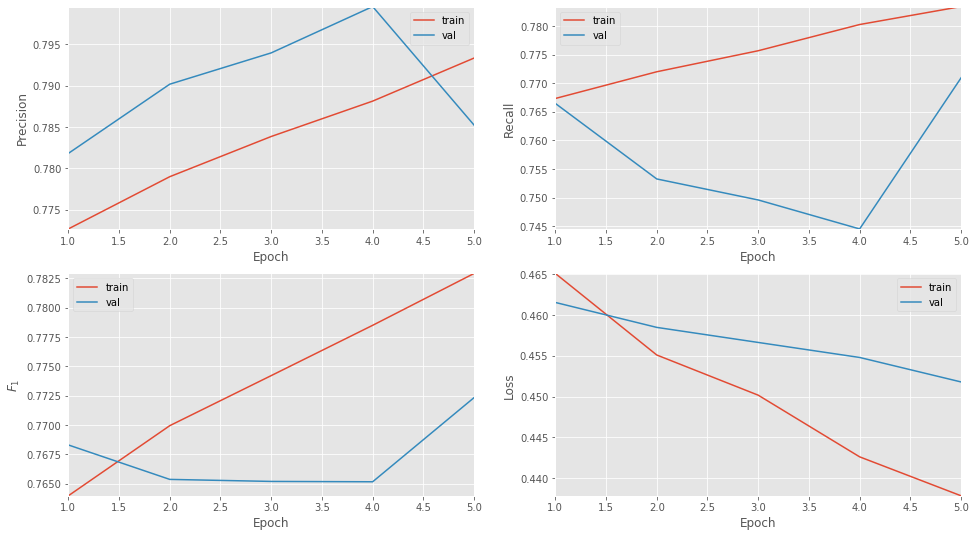

In [51]:
plot_history(history_trainable)

In [55]:
model.load_weights('cnn-trainable-01-0.77.hdf5')

In [56]:
predicted = np.round(model.predict(x_test_seq))
print(classification_report(y_test, predicted, digits=5))

              precision    recall  f1-score   support

           0    0.76725   0.78635   0.77668     22457
           1    0.77944   0.75992   0.76956     22313

    accuracy                        0.77317     44770
   macro avg    0.77335   0.77313   0.77312     44770
weighted avg    0.77333   0.77317   0.77313     44770

